<a href="https://colab.research.google.com/github/Chirag314/Tabular-Data-Series/blob/main/tds_sep_22_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to make a submission to the Tabular Playground Series (Sep 2022) Using Ensemble Models

In [255]:
# Import Python packages
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score,TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import itertools

from sklearn import metrics

In [256]:
# print list of all data and files attached to this notebook
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/.config/active_config
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_opt_in_prompt.yaml
/content/.config/config_sentinel
/content/.config/gce
/content/.config/configurations/config_default
/content/.config/logs/2022.09.22/13.41.33.220849.log
/content/.config/logs/2022.09.22/13.40.36.582025.log
/content/.config/logs/2022.09.22/13.41.55.898378.log
/content/.config/logs/2022.09.22/13.41.56.678942.log
/content/.config/logs/2022.09.22/13.41.24.425810.log
/content/.config/logs/2022.09.22/13.41.02.490980.log
/content/Sept/train.csv
/content/Sept/sample_submission .csv
/content/Sept/test.csv
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_test.csv


Step 3: Load the data

In [297]:
# load to pandas dataframe (for data exploration)
train_df = pd.read_csv('Sept/train.csv')
test_df = pd.read_csv('Sept/test.csv')
test_df1=test_df.copy()


Step 4: Explore the data

In [258]:
# print column names
print(train_df.columns)
print(train_df.shape)

Index(['row_id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')
(70128, 6)


It is a tabular dataset with ~70,000 rows and 6 columns (4.49MB .CSV training dataset + 1.06MB .CSV test set) that is suitable for training regression algorithms (in this case to determine the number of units sold ("num_sold")).

In [259]:
# preview first few rows of data
train_df.head(10)

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267
8,8,2017-01-01,France,KaggleMart,Kaggle Advanced Techniques,610
9,9,2017-01-01,France,KaggleMart,Kaggle Getting Started,463


In [260]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [261]:
# print basic summary statistics
train_df.describe().head(3)
# For additional summary statistics you can run the following few lines as well:
# from pandas_profiling import ProfileReport
# # train_profile = ProfileReport(train_df, title="September 2022 Tabular Data Series")
# # train_profile

,row_id,num_sold
count,70128.000000,70128.000000
mean,35063.500000,194.296986
std,20244.354176,126.893874


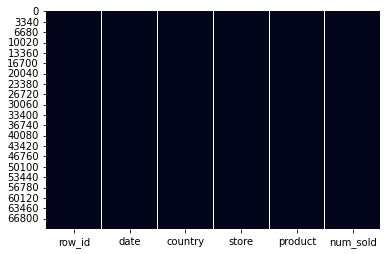

In [262]:
# check for missing values
sns.heatmap(train_df.isnull(), cbar=False)

RandomForest and GradientBoostedTrees deal with null values automatically but for improved model performance we might consider handling these missing values in a more thoughtful way.  To learn more about data imputation techniques, consider reviewing the relevant Kaggle Learn exercise [here](https://www.kaggle.com/code/alexisbcook/missing-values).

Step 5: Feature Engineering and Feature Selection

In [263]:
train_df.dtypes

row_id       int64
date        object
country     object
store       object
product     object
num_sold     int64
dtype: object

In [264]:
#  ADD CONTENT HERE TO IMPROVE YOUR SCORE!
#Set the row_id column as the index
train_df=train_df.set_index("row_id")

# convert date column to datetime 
train_df['date']=pd.to_datetime(train_df['date'])


In [265]:
# Check how many countries and value counts of countries
train_df['country'].value_counts()


Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: country, dtype: int64

It seems data is equally divided between countries

To get to the top of the leaderboard it will be important to do a lot of clever feature engineering and feature selection. You can learn more about these concepts by reviewing the relevant Kaggle Learn exercise [here]((https://www.kaggle.com/learn/feature-engineering)). These steps were intentionally skipped in this tutorial for the sake of brevity.

In [266]:
# Check with no of stores
train_df['store'].value_counts()
# Store are also balanced

KaggleMart    35064
KaggleRama    35064
Name: store, dtype: int64

In [268]:
# Check product distribution
train_df['product'].value_counts()
# Data is uniformly distributed amonst products as well

Kaggle Advanced Techniques          17532
Kaggle Getting Started              17532
Kaggle Recipe Book                  17532
Kaggle for Kids: One Smart Goose    17532
Name: product, dtype: int64

In [269]:
# Check distribution of numeric data
train_df.describe()

,num_sold
count,70128.000000
mean,194.296986
std,126.893874
min,19.000000
25%,95.000000
50%,148.000000
75%,283.000000
max,986.000000


In [270]:
# check number of books sold
book_sales_df=train_df.groupby('product')['num_sold'].sum().reset_index().sort_values('num_sold',ascending=False)
book_sales_df

,product,num_sold
3,Kaggle for Kids: One Smart Goose,4225029
0,Kaggle Advanced Techniques,3913910
1,Kaggle Getting Started,3136903
2,Kaggle Recipe Book,2349817


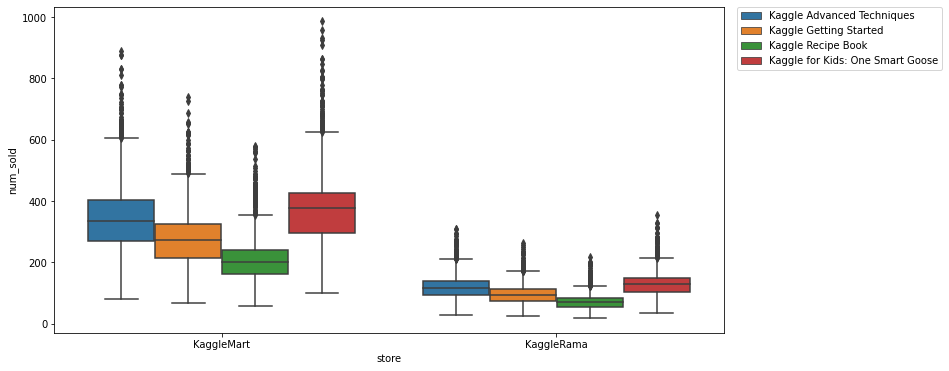

In [271]:
# Find out which store sold more books
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df,x='store',y='num_sold',hue='product')
plt.legend(bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0)

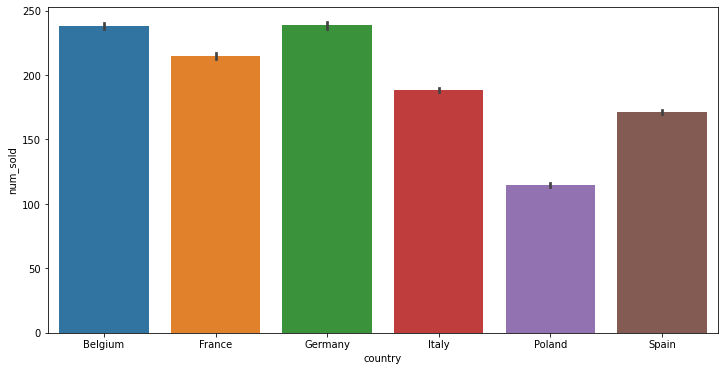

In [272]:
# Find out which country soldl more books
plt.figure(figsize=(12,6))
sns.barplot(data=train_df,x='country',y='num_sold')

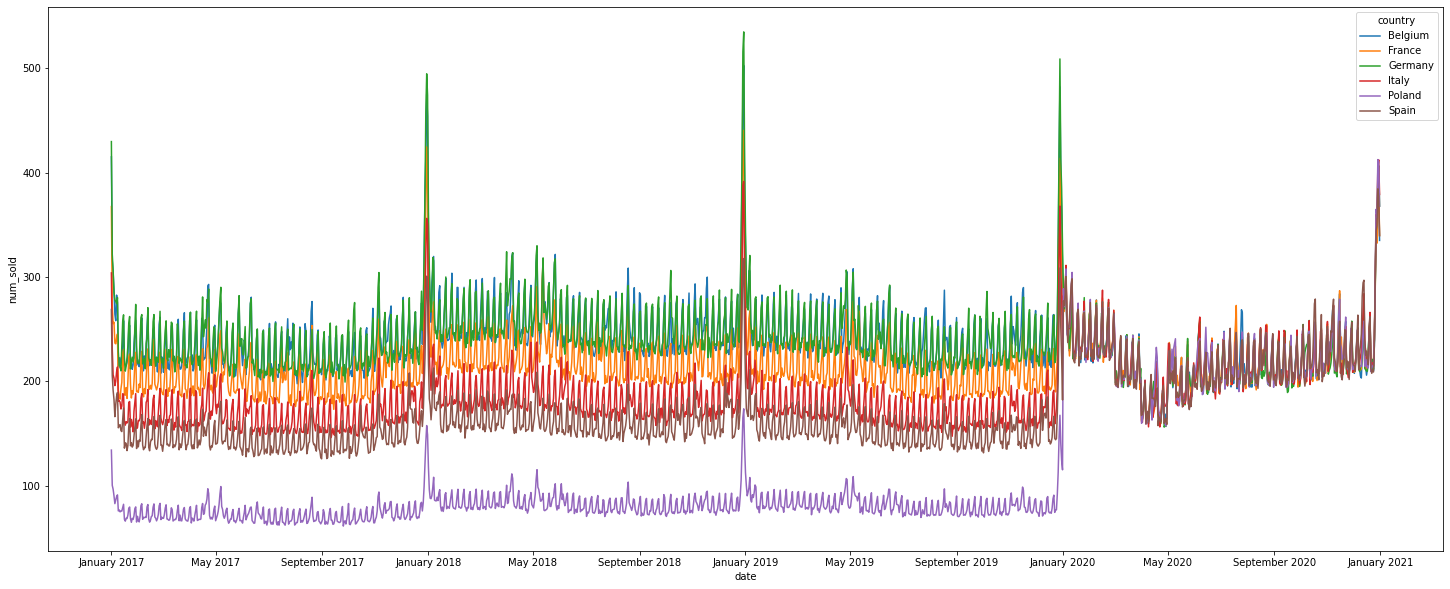

In [273]:
# Check the sales distribution by month
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.figure(figsize=(25,10))

# Time series plot of books sold
ts=sns.lineplot(
    data=train_df,
    x='date',
    y='num_sold',
    hue='country',
    ci=None
)

ts.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ts.xaxis.set_major_formatter(DateFormatter("%B %Y"))

In [274]:
# Separate date into different features
train_df['day_name']=train_df['date'].apply(lambda x:pd.Timestamp(x).day_name())
train_df['day']=train_df['date'].apply(lambda x:pd.Timestamp(x).day)
train_df['month']=train_df['date'].apply(lambda x:pd.Timestamp(x).month_name())
train_df['year']=train_df['date'].apply(lambda x:pd.Timestamp(x).year)



In [275]:
test_df['day_name']=test_df['date'].apply(lambda x:pd.Timestamp(x).day_name())
test_df['day']=test_df['date'].apply(lambda x:pd.Timestamp(x).day)
test_df['month']=test_df['date'].apply(lambda x:pd.Timestamp(x).month_name())
test_df['year']=test_df['date'].apply(lambda x:pd.Timestamp(x).year)

In [276]:
#sort dataset
cols=['date','day_name','day','month','year','country','store','product','num_sold']
train_df=train_df[cols]
train_df.head()

,date,day_name,day,month,year,country,store,product,num_sold
row_id,,,,,,,,,
0,2017-01-01,Sunday,1,January,2017,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Sunday,1,January,2017,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Sunday,1,January,2017,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Sunday,1,January,2017,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Sunday,1,January,2017,Belgium,KaggleRama,Kaggle Advanced Techniques,240


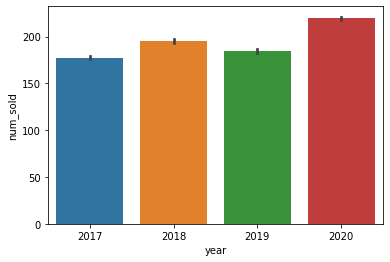

In [277]:
# Now check books sold by year
sns.barplot(data=train_df,x='year',y='num_sold')
# 2020 sold most number of books

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

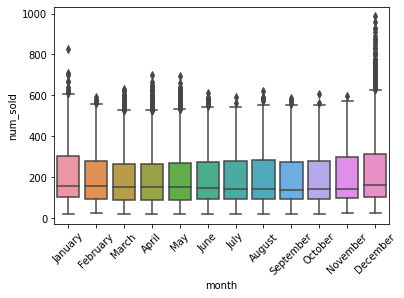

In [278]:
# Check number of books sold by month
sns.boxplot(data=train_df,x='month',y='num_sold')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

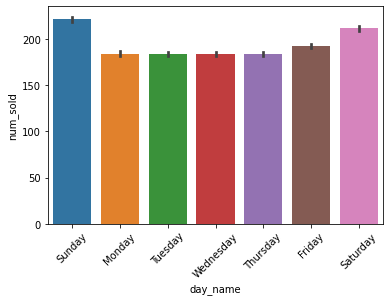

In [279]:
# Check distribution by day
sns.barplot(data=train_df,x='day_name',y='num_sold')
plt.xticks(rotation=45)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


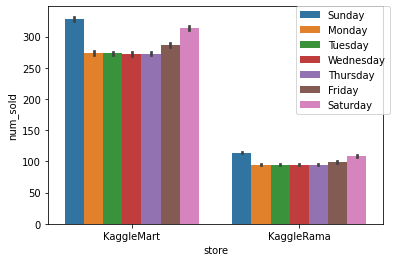

In [280]:
# Check store*days distribution
sns.barplot(data=train_df,x='store',y='num_sold',hue='day_name')
plt.legend(bbox_to_anchor=(1.02,1),loc='upper_left',borderaxespad=0)

Both store sale more books on weekends

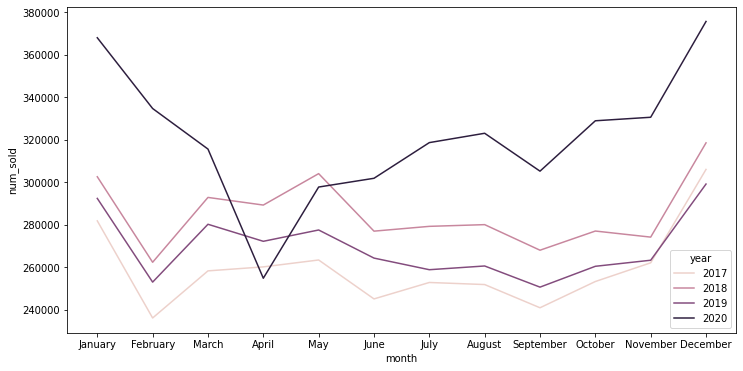

In [281]:
# Check which month has most sales
plt.figure(figsize=(12,6))
sns.lineplot(
    data=train_df,
    x='month',
    y='num_sold',
    hue='year',
    estimator=sum,
    ci=None
)

In [282]:
# One hot encoding of categorical columns
train_df = pd.get_dummies(train_df, columns = ['country', 'store','product','day_name','month'])

train_df.head()

,date,day,year,num_sold,country_Belgium,country_France,country_Germany,country_Italy,country_Poland,country_Spain,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
row_id,,,,,,,,,,,,,,,,,,,,,
0,2017-01-01,1,2017,663,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2017-01-01,1,2017,615,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2017-01-01,1,2017,480,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2017-01-01,1,2017,710,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2017-01-01,1,2017,240,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [283]:
test_df = pd.get_dummies(test_df, columns = ['country', 'store','product','day_name','month'])

test_df.head()

,row_id,date,day,year,country_Belgium,country_France,country_Germany,country_Italy,country_Poland,country_Spain,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,70128,2021-01-01,1,2021,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,70129,2021-01-01,1,2021,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,70130,2021-01-01,1,2021,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,70131,2021-01-01,1,2021,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,70132,2021-01-01,1,2021,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [284]:
train_df.dtypes

date                                        datetime64[ns]
day                                                  int64
year                                                 int64
num_sold                                             int64
country_Belgium                                      uint8
country_France                                       uint8
country_Germany                                      uint8
country_Italy                                        uint8
country_Poland                                       uint8
country_Spain                                        uint8
store_KaggleMart                                     uint8
store_KaggleRama                                     uint8
product_Kaggle Advanced Techniques                   uint8
product_Kaggle Getting Started                       uint8
product_Kaggle Recipe Book                           uint8
product_Kaggle for Kids: One Smart Goose             uint8
day_name_Friday                                      uin

In [285]:
#Separete data and labels
X=train_df.drop(['num_sold' ],axis=1)
Y=train_df['num_sold']
Y.head()

row_id
0    663
1    615
2    480
3    710
4    240
Name: num_sold, dtype: int64

In [286]:
X.dtypes

date                                        datetime64[ns]
day                                                  int64
year                                                 int64
country_Belgium                                      uint8
country_France                                       uint8
country_Germany                                      uint8
country_Italy                                        uint8
country_Poland                                       uint8
country_Spain                                        uint8
store_KaggleMart                                     uint8
store_KaggleRama                                     uint8
product_Kaggle Advanced Techniques                   uint8
product_Kaggle Getting Started                       uint8
product_Kaggle Recipe Book                           uint8
product_Kaggle for Kids: One Smart Goose             uint8
day_name_Friday                                      uint8
day_name_Monday                                      uin

In [287]:
X.drop(columns=[ 'date'], inplace=True)
Y.drop(columns=['row_id', 'date'], inplace=True)
test_df.drop(columns=['date','row_id'], inplace=True)

In [288]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)

In [289]:
# Create metrics 
from sklearn.metrics import * 
def metrics(y_test,pred):
    print("RMSE is ", mean_squared_error(y_test,pred))
    
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

Check different model and their ourput errors

In [290]:
from sklearn.linear_model import *
lr=LinearRegression()
lr.fit(x_train,y_train)
pred=lr.predict(x_test)
metrics(y_test,pred)
smape(y_test,pred)

RMSE is  3165.160547683807


31.578580747471104

In [291]:
from sklearn.ensemble import HistGradientBoostingRegressor
clf=HistGradientBoostingRegressor()
clf.fit(x_train,y_train)
pred=clf.predict(x_test)
metrics(y_test,pred)
smape(y_test,pred)

RMSE is  257.08032756233894


5.970373854503416

In [292]:
from xgboost.sklearn import XGBRegressor
import xgboost
xgb=XGBRegressor(n_estimators=200,max_depth=8)
xgb.fit(x_train,y_train)
pred=xgb.predict(x_test)
metrics(y_test,pred)
smape(y_test,pred)


[03:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE is  175.77103580567626


4.577103402485637

#Select best model

In [293]:
test_df.dtypes

day                                         int64
year                                        int64
country_Belgium                             uint8
country_France                              uint8
country_Germany                             uint8
country_Italy                               uint8
country_Poland                              uint8
country_Spain                               uint8
store_KaggleMart                            uint8
store_KaggleRama                            uint8
product_Kaggle Advanced Techniques          uint8
product_Kaggle Getting Started              uint8
product_Kaggle Recipe Book                  uint8
product_Kaggle for Kids: One Smart Goose    uint8
day_name_Friday                             uint8
day_name_Monday                             uint8
day_name_Saturday                           uint8
day_name_Sunday                             uint8
day_name_Thursday                           uint8
day_name_Tuesday                            uint8


In [294]:
test_pred=xgb.predict(test_df)

In [298]:
submission=pd.DataFrame({"num_sold":test_pred},index=test_df1.row_id)
submission.to_csv("submissions2.csv")
